In [1]:
from pydub import AudioSegment
from tqdm import tqdm
import librosa
import soundfile as sf
import os
import gc
import numpy as np
from matplotlib import pyplot as plt
import warnings
import tensorflow as tf

In [5]:
from tensorflow.keras.models import load_model

data_dir = [r'E:\Mini_Project\Review_1_data']
# Loading the Models
model = load_model(r'E:\Mini_Project\Review_1_model\crnn2d_thaatclassifier.h5')

models = {}
for i in os.listdir(data_dir[0]):
    filename = i+".h5"
    models[i] = load_model("E:/Mini_Project/Review_2_models/"+filename)

In [13]:
#@title Creating Data Pipeline

import numpy as np
data_dir = [r'E:\Mini_Project\Review_1_data']
data = tf.keras.utils.image_dataset_from_directory('E:\Mini_Project\Review_1_data', shuffle=True)
data_iterator = data.as_numpy_iterator()

datas = {}
data_iterators = {}
for i in os.listdir(data_dir[0]):
    datas[i] = tf.keras.utils.image_dataset_from_directory(os.path.join(data_dir[0], i), shuffle=True)
    data_iterators[i] = datas[i].as_numpy_iterator()


Found 10566 files belonging to 10 classes.
Found 868 files belonging to 5 classes.
Found 1048 files belonging to 7 classes.
Found 939 files belonging to 5 classes.
Found 1223 files belonging to 8 classes.
Found 1712 files belonging to 7 classes.
Found 1198 files belonging to 6 classes.
Found 698 files belonging to 5 classes.
Found 725 files belonging to 5 classes.
Found 1360 files belonging to 7 classes.
Found 795 files belonging to 4 classes.


In [14]:
#@title Preprocessing Data

''' Scaling Data '''
# Scaling Data
data = data.map(lambda x,y: (x/255, y))
for i in os.listdir(data_dir[0]):
    datas[i] = datas[i].map(lambda x,y: (x/255, y))

''' Splitting Data '''
train_size = int(len(data)*.8)
val_size = int(len(data)*.1)+1
test_size = int(len(data)*.1)+1

train = data.take(train_size)
val = data.take(val_size)
test = data.take(test_size)

trains = {}
tests = {}
vals = {}
for i in os.listdir(data_dir[0]):
    train_size = int(len(datas[i])*.8)
    val_size = int(len(datas[i])*.1)+1
    test_size = int(len(datas[i])*.1)+1
    print("For "+i+" : ", train_size, " + ", val_size, " + ", test_size, " = ", len(datas[i]))

    trains[i] = datas[i].take(train_size)
    vals[i] = datas[i].take(val_size)
    tests[i] = datas[i].take(test_size)

For Thaat_Asavari :  22  +  3  +  3  =  28
For Thaat_Bhairav :  26  +  4  +  4  =  33
For Thaat_Bhairavi :  24  +  4  +  4  =  30
For Thaat_Bilawal :  31  +  4  +  4  =  39
For Thaat_Kafi :  43  +  6  +  6  =  54
For Thaat_Kalyan :  30  +  4  +  4  =  38
For Thaat_Khamaj :  17  +  3  +  3  =  22
For Thaat_Marwa :  18  +  3  +  3  =  23
For Thaat_Purvi :  34  +  5  +  5  =  43
For Thaat_Todi :  20  +  3  +  3  =  25


In [45]:
#@title Functions

import pandas as pd
import numpy as np
from sklearn.metrics import *
import math, os
from sklearn.preprocessing import label_binarize

#ROC-AUC
from sklearn.metrics import roc_curve,auc
import matplotlib.pyplot as plt

def plot_roc(val_label,decision_val, caption='ROC Curve'):
    num_classes=np.unique(val_label).shape[0]
    classes = []
    for i in range(num_classes):
        classes.append(i)
    plt.figure()
    decision_val = label_binarize(decision_val, classes=classes)

    if num_classes!=2:
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(num_classes):
            y_val = label_binarize(val_label, classes=classes)
            fpr[i], tpr[i], _ = roc_curve(y_val[:, i], decision_val[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        for i in range(num_classes):
            plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                           ''.format(i+1, roc_auc[i]))
    else:
        fpr,tpr,_ = roc_curve(val_label,decision_val, pos_label=1)
        roc_auc = auc(fpr,tpr)*100
        plt.plot(fpr,tpr,label='ROC curve (AUC=%0.2f)'%roc_auc)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(caption)
    plt.legend(loc="lower right",  bbox_to_anchor=(1, 0.5))
    plt.savefig(str(len(classes))+'.png',dpi=300)

def predicting(ensemble_prob):
    prediction = np.zeros((ensemble_prob.shape[0],))
    for i in range(ensemble_prob.shape[0]):
        temp = ensemble_prob[i]
        t = np.where(temp == np.max(temp))[0][0]
        prediction[i] = t
    return prediction

def metrics(labels, predictions, classes):
    print("Classification Report:")
    print("Labels : ",labels.shape, '\nPredictions : ', predictions.shape)
    print(classification_report(labels, predictions, target_names = classes, digits = 4))
    matrix = confusion_matrix(labels, predictions)
    print("Confusion matrix:")
    print(matrix)
    display = ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = classes)
    display.plot()
    plt.show()
    print("\nClasswise Accuracy :{}".format(matrix.diagonal()/matrix.sum(axis = 1)))
    print("\nBalanced Accuracy Score: ",balanced_accuracy_score(labels,predictions))

For Model CRNN2D: 
Classification Report:
Labels :  (1088,) 
Predictions :  (1088,)
              precision    recall  f1-score   support

           1     1.0000    0.9804    0.9901       102
           2     0.9608    0.8991    0.9289       109
           3     0.9510    0.9510    0.9510       102
           4     0.9769    0.9695    0.9732       131
           5     0.9689    0.9455    0.9571       165
           6     0.9478    0.9561    0.9520       114
           7     0.9589    0.9589    0.9589        73
           8     0.9868    1.0000    0.9934        75
           9     0.9924    0.9562    0.9740       137
          10     0.8247    1.0000    0.9040        80

    accuracy                         0.9586      1088
   macro avg     0.9568    0.9617    0.9582      1088
weighted avg     0.9610    0.9586    0.9590      1088

Confusion matrix:
[[100   1   0   0   0   1   0   0   0   0]
 [  0  98   1   0   1   2   0   0   1   6]
 [  0   1  97   0   1   0   1   0   0   2]
 [  0   1 

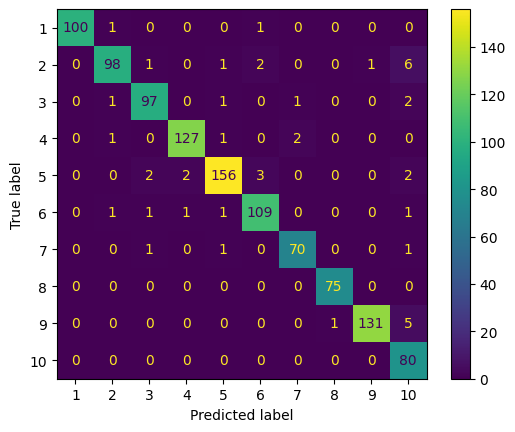


Classwise Accuracy :[0.98039216 0.89908257 0.95098039 0.96946565 0.94545455 0.95614035
 0.95890411 1.         0.95620438 1.        ]

Balanced Accuracy Score:  0.9616624152164732
Accuracy[0.9586] Precision[0.9568] Recall[0.9617] F1[0.9582] ]
________________________________________________________________


Overall Accuracy[0.9586] Overall Precision[0.9568] Overall Recall[0.9617] Overall F1[0.9582]
For Thaat_Asavari: 
Classification Report:
Labels :  (96,) 
Predictions :  (96,)
              precision    recall  f1-score   support

           1     0.7857    0.8462    0.8148        13
           2     1.0000    0.6923    0.8182        13
           3     0.8889    1.0000    0.9412        32
           4     0.9231    1.0000    0.9600        12
           5     0.9583    0.8846    0.9200        26

    accuracy                         0.9062        96
   macro avg     0.9112    0.8846    0.8908        96
weighted avg     0.9130    0.9062    0.9040        96

Confusion matrix:
[[11  0  

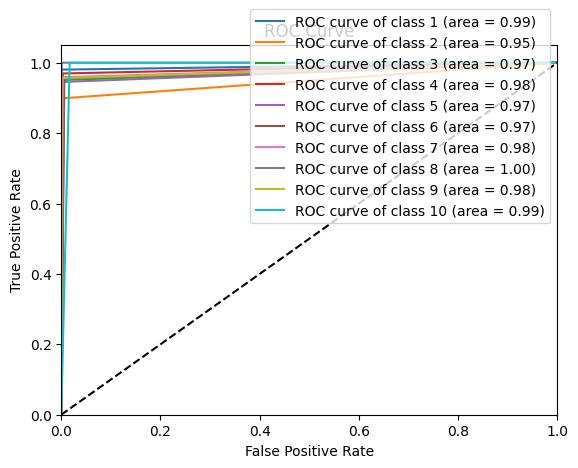

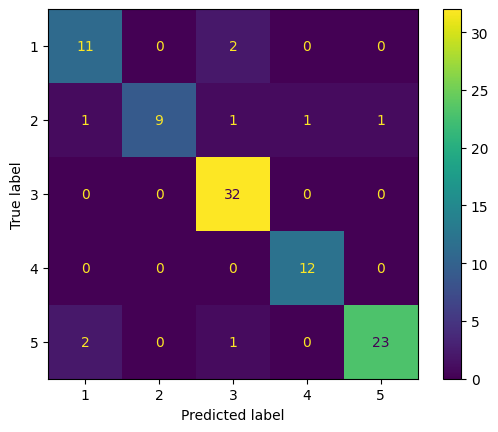


Classwise Accuracy :[0.84615385 0.69230769 1.         1.         0.88461538]

Balanced Accuracy Score:  0.8846153846153847
Accuracy[0.9062] Precision[0.9112] Recall[0.8846] F1[0.8908] ]
________________________________________________________________


Overall Accuracy[0.9062] Overall Precision[0.9112] Overall Recall[0.8846] Overall F1[0.8908]
For Thaat_Bhairav: 
Classification Report:
Labels :  (128,) 
Predictions :  (128,)
              precision    recall  f1-score   support

           1     0.9333    0.9655    0.9492        29
           2     0.8519    1.0000    0.9200        23
           3     0.9286    1.0000    0.9630        13
           4     1.0000    0.8400    0.9130        25
           5     1.0000    1.0000    1.0000        12
           6     1.0000    1.0000    1.0000        16
           7     1.0000    0.8000    0.8889        10

    accuracy                         0.9453       128
   macro avg     0.9591    0.9436    0.9477       128
weighted avg     0.9510    0

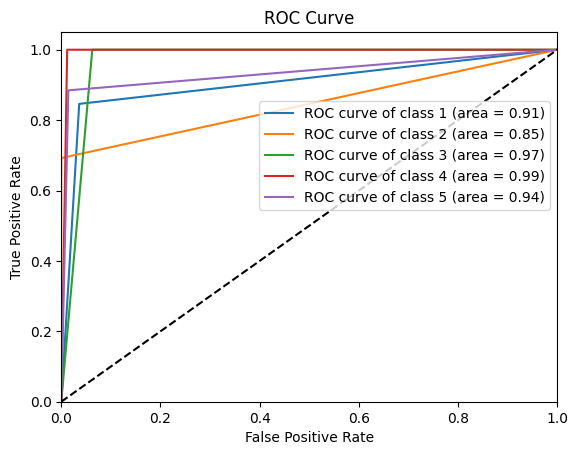

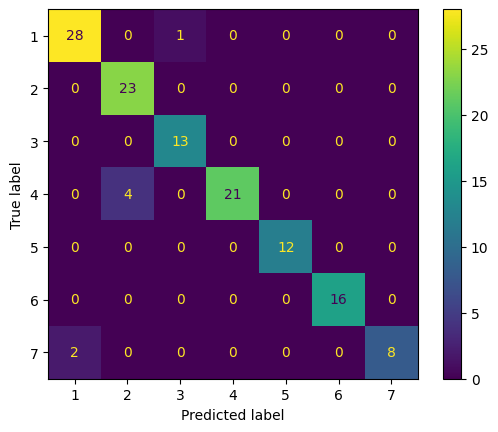


Classwise Accuracy :[0.96551724 1.         1.         0.84       1.         1.
 0.8       ]

Balanced Accuracy Score:  0.9436453201970443
Accuracy[0.9453] Precision[0.9591] Recall[0.9436] F1[0.9477] ]
________________________________________________________________


Overall Accuracy[0.9453] Overall Precision[0.9591] Overall Recall[0.9436] Overall F1[0.9477]
For Thaat_Bhairavi: 
Classification Report:
Labels :  (128,) 
Predictions :  (128,)
              precision    recall  f1-score   support

           1     0.8462    0.9167    0.8800        12
           2     0.9444    1.0000    0.9714        17
           3     0.9259    0.8621    0.8929        29
           4     1.0000    1.0000    1.0000        22
           5     0.9167    0.9167    0.9167        48

    accuracy                         0.9297       128
   macro avg     0.9266    0.9391    0.9322       128
weighted avg     0.9302    0.9297    0.9294       128

Confusion matrix:
[[11  0  0  0  1]
 [ 0 17  0  0  0]
 [ 0  1 25 

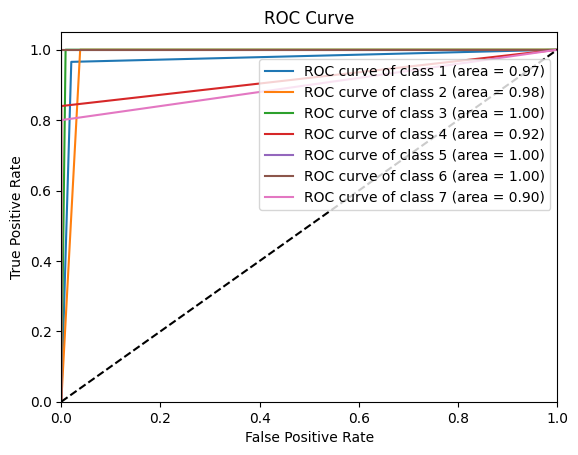

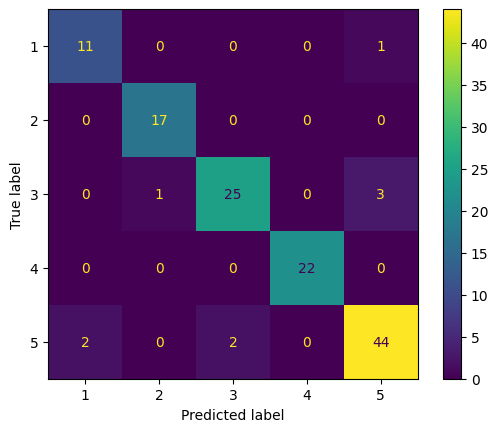


Classwise Accuracy :[0.91666667 1.         0.86206897 1.         0.91666667]

Balanced Accuracy Score:  0.939080459770115
Accuracy[0.9297] Precision[0.9266] Recall[0.9391] F1[0.9322] ]
________________________________________________________________


Overall Accuracy[0.9297] Overall Precision[0.9266] Overall Recall[0.9391] Overall F1[0.9322]
For Thaat_Bilawal: 
Classification Report:
Labels :  (128,) 
Predictions :  (128,)
              precision    recall  f1-score   support

           1     1.0000    0.8182    0.9000        22
           2     1.0000    1.0000    1.0000         6
           3     0.8148    1.0000    0.8980        22
           4     0.9333    1.0000    0.9655        14
           5     0.9500    1.0000    0.9744        19
           6     1.0000    0.8571    0.9231        21
           7     1.0000    1.0000    1.0000        14
           8     1.0000    1.0000    1.0000        10

    accuracy                         0.9453       128
   macro avg     0.9623    0.

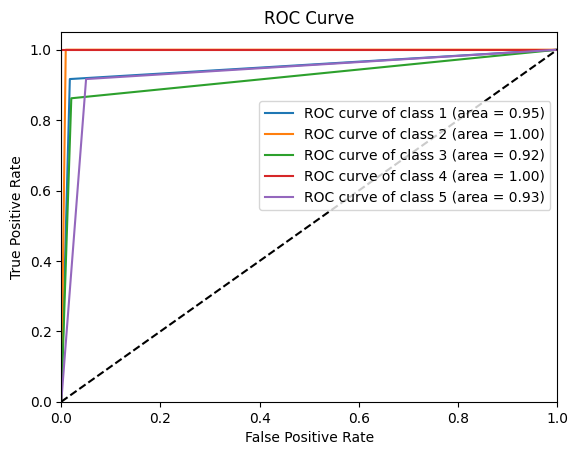

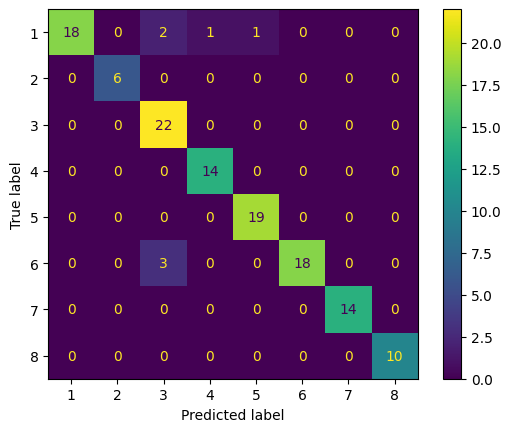


Classwise Accuracy :[0.81818182 1.         1.         1.         1.         0.85714286
 1.         1.        ]

Balanced Accuracy Score:  0.9594155844155845
Accuracy[0.9453] Precision[0.9623] Recall[0.9594] F1[0.9576] ]
________________________________________________________________


Overall Accuracy[0.9453] Overall Precision[0.9623] Overall Recall[0.9594] Overall F1[0.9576]
For Thaat_Kafi: 
Classification Report:
Labels :  (192,) 
Predictions :  (192,)
              precision    recall  f1-score   support

           1     1.0000    0.6818    0.8108        22
           2     0.9394    0.8378    0.8857        37
           3     0.7941    0.9643    0.8710        28
           4     0.9677    0.9091    0.9375        33
           5     0.8824    0.8824    0.8824        17
           6     0.7500    0.9091    0.8219        33
           7     0.8636    0.8636    0.8636        22

    accuracy                         0.8698       192
   macro avg     0.8853    0.8640    0.8676       1

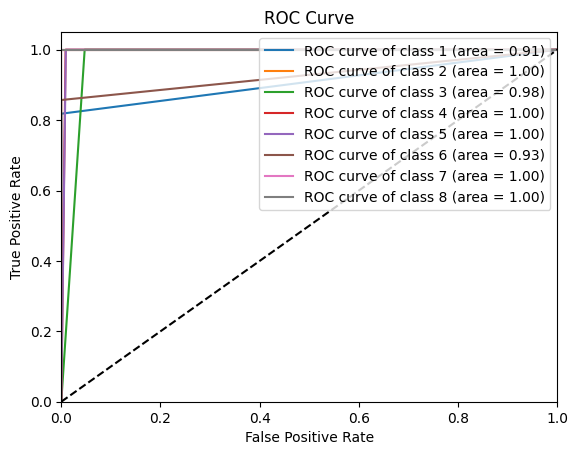

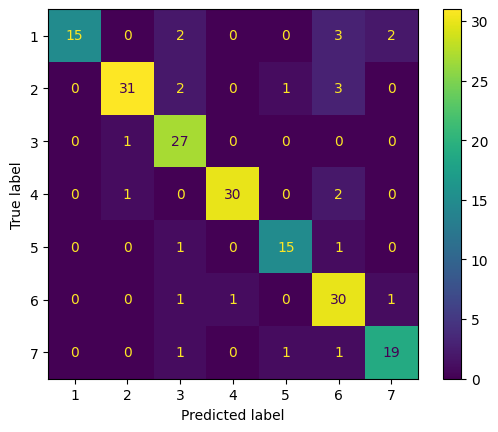


Classwise Accuracy :[0.68181818 0.83783784 0.96428571 0.90909091 0.88235294 0.90909091
 0.86363636]

Balanced Accuracy Score:  0.8640161224194837
Accuracy[0.8698] Precision[0.8853] Recall[0.8640] F1[0.8676] ]
________________________________________________________________


Overall Accuracy[0.8698] Overall Precision[0.8853] Overall Recall[0.8640] Overall F1[0.8676]
For Thaat_Kalyan: 
Classification Report:
Labels :  (128,) 
Predictions :  (128,)
              precision    recall  f1-score   support

           1     0.8750    0.9130    0.8936        23
           2     0.8667    0.9286    0.8966        14
           3     0.9000    1.0000    0.9474        18
           4     0.8800    0.8800    0.8800        25
           5     1.0000    1.0000    1.0000        12
           6     0.9375    0.8333    0.8824        36

    accuracy                         0.9062       128
   macro avg     0.9099    0.9258    0.9166       128
weighted avg     0.9079    0.9062    0.9056       128

Confu

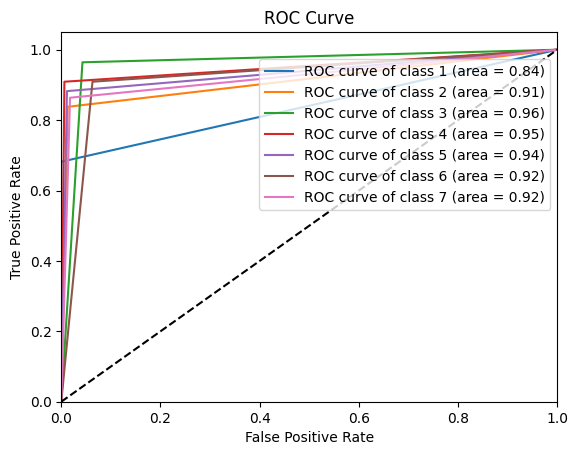

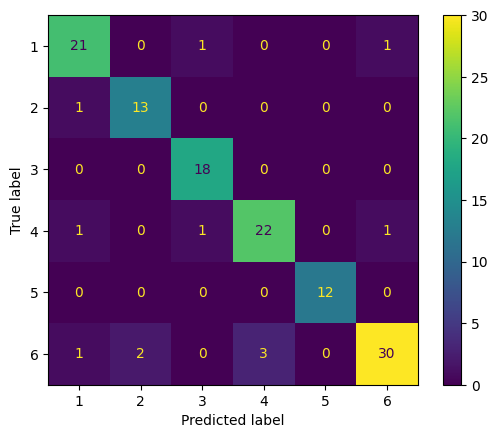


Classwise Accuracy :[0.91304348 0.92857143 1.         0.88       1.         0.83333333]

Balanced Accuracy Score:  0.9258247066942719
Accuracy[0.9062] Precision[0.9099] Recall[0.9258] F1[0.9166] ]
________________________________________________________________


Overall Accuracy[0.9062] Overall Precision[0.9099] Overall Recall[0.9258] Overall F1[0.9166]
For Thaat_Khamaj: 
Classification Report:
Labels :  (96,) 
Predictions :  (96,)
              precision    recall  f1-score   support

           1     0.7778    0.8750    0.8235        16
           2     1.0000    0.8824    0.9375        17
           3     0.9545    0.8750    0.9130        24
           4     0.9565    0.9167    0.9362        24
           5     0.8333    1.0000    0.9091        15

    accuracy                         0.9062        96
   macro avg     0.9044    0.9098    0.9039        96
weighted avg     0.9147    0.9062    0.9076        96

Confusion matrix:
[[14  0  0  1  1]
 [ 1 15  0  0  1]
 [ 3  0 21  0  0]
 

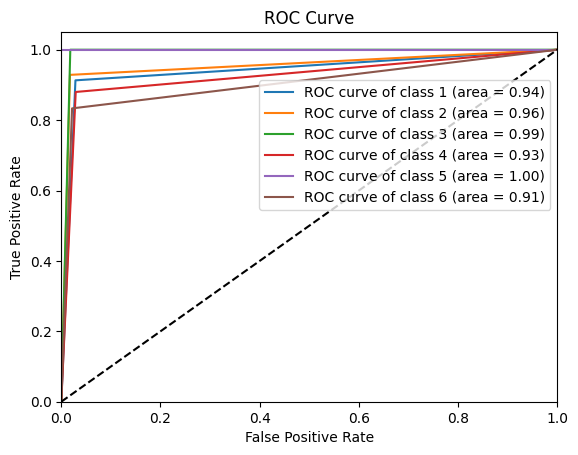

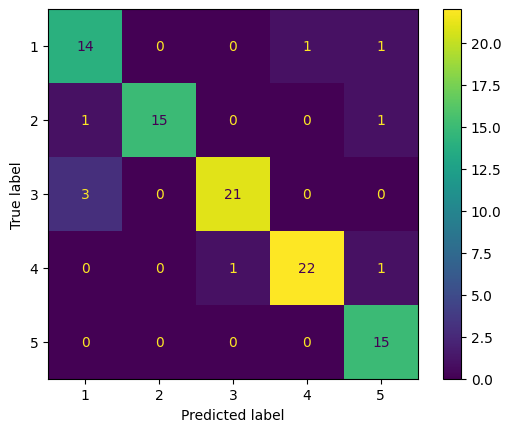


Classwise Accuracy :[0.875      0.88235294 0.875      0.91666667 1.        ]

Balanced Accuracy Score:  0.9098039215686274
Accuracy[0.9062] Precision[0.9044] Recall[0.9098] F1[0.9039] ]
________________________________________________________________


Overall Accuracy[0.9062] Overall Precision[0.9044] Overall Recall[0.9098] Overall F1[0.9039]
For Thaat_Marwa: 
Classification Report:
Labels :  (96,) 
Predictions :  (96,)
              precision    recall  f1-score   support

           1     0.9091    1.0000    0.9524        10
           2     0.9655    0.9655    0.9655        29
           3     1.0000    1.0000    1.0000        16
           4     1.0000    1.0000    1.0000        25
           5     1.0000    0.9375    0.9677        16

    accuracy                         0.9792        96
   macro avg     0.9749    0.9806    0.9771        96
weighted avg     0.9801    0.9792    0.9792        96

Confusion matrix:
[[10  0  0  0  0]
 [ 1 28  0  0  0]
 [ 0  0 16  0  0]
 [ 0  0  0 25

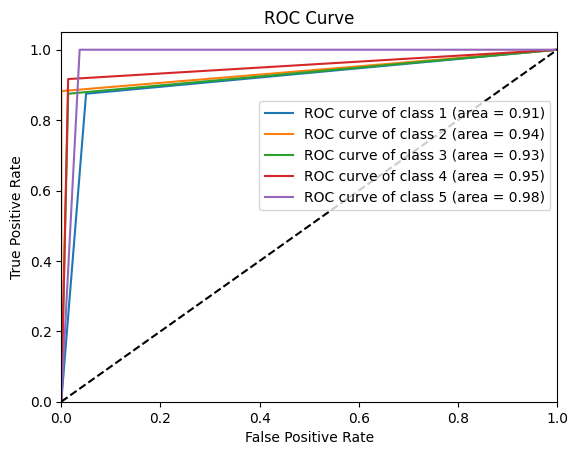

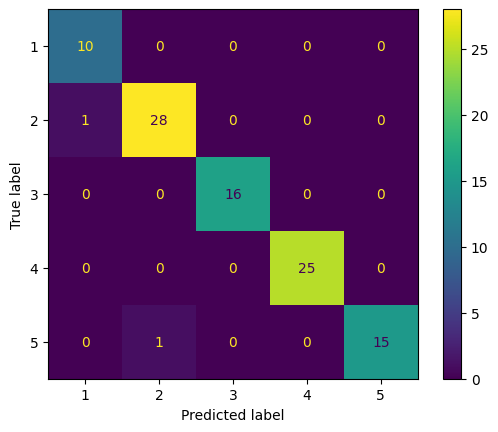


Classwise Accuracy :[1.         0.96551724 1.         1.         0.9375    ]

Balanced Accuracy Score:  0.9806034482758621
Accuracy[0.9792] Precision[0.9749] Recall[0.9806] F1[0.9771] ]
________________________________________________________________


Overall Accuracy[0.9792] Overall Precision[0.9749] Overall Recall[0.9806] Overall F1[0.9771]
For Thaat_Purvi: 
Classification Report:
Labels :  (160,) 
Predictions :  (160,)
              precision    recall  f1-score   support

           1     0.8421    0.8421    0.8421        19
           2     0.9286    1.0000    0.9630        13
           3     1.0000    1.0000    1.0000        10
           4     0.9000    0.8438    0.8710        32
           5     0.8261    0.9048    0.8636        21
           6     1.0000    0.7619    0.8649        21
           7     0.8750    0.9545    0.9130        44

    accuracy                         0.8938       160
   macro avg     0.9103    0.9010    0.9025       160
weighted avg     0.8982    0.8

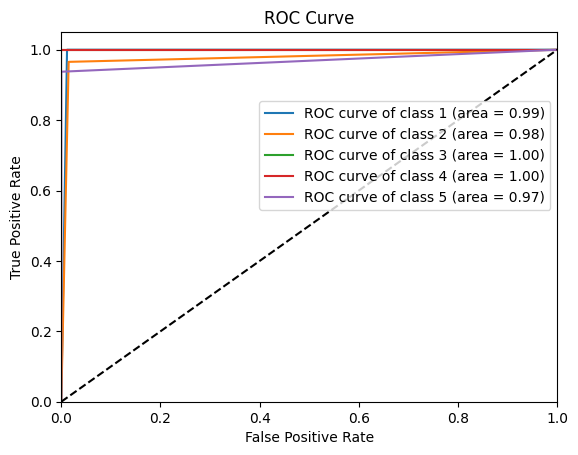

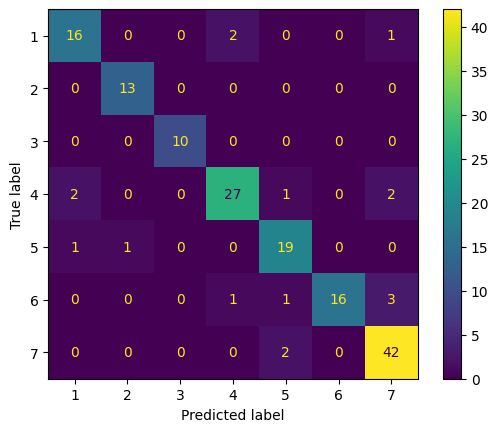


Classwise Accuracy :[0.84210526 1.         1.         0.84375    0.9047619  0.76190476
 0.95454545]

Balanced Accuracy Score:  0.9010096263385738
Accuracy[0.8938] Precision[0.9103] Recall[0.9010] F1[0.9025] ]
________________________________________________________________


Overall Accuracy[0.8938] Overall Precision[0.9103] Overall Recall[0.9010] Overall F1[0.9025]
For Thaat_Todi: 
Classification Report:
Labels :  (96,) 
Predictions :  (96,)
              precision    recall  f1-score   support

           1     1.0000    0.9286    0.9630        14
           2     0.9375    1.0000    0.9677        30
           3     1.0000    1.0000    1.0000        14
           4     0.9730    0.9474    0.9600        38

    accuracy                         0.9688        96
   macro avg     0.9776    0.9690    0.9727        96
weighted avg     0.9698    0.9688    0.9687        96

Confusion matrix:
[[13  0  0  1]
 [ 0 30  0  0]
 [ 0  0 14  0]
 [ 0  2  0 36]]


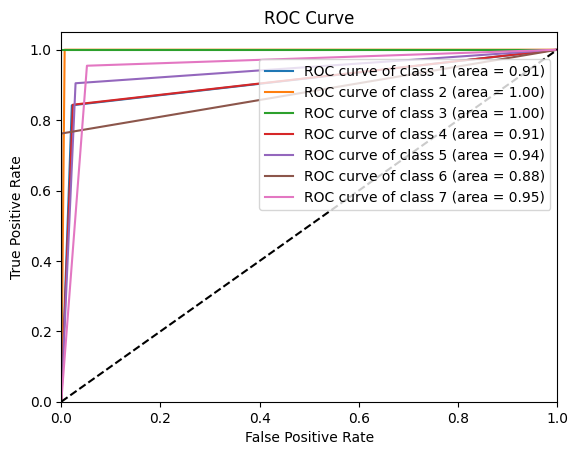

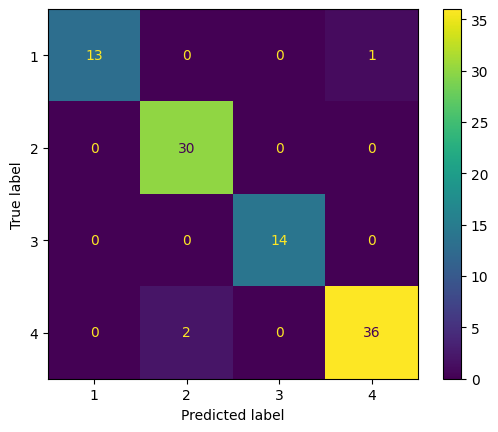


Classwise Accuracy :[0.92857143 1.         1.         0.94736842]

Balanced Accuracy Score:  0.9689849624060151
Accuracy[0.9688] Precision[0.9776] Recall[0.9690] F1[0.9727] ]
________________________________________________________________


Overall Accuracy[0.9688] Overall Precision[0.9776] Overall Recall[0.9690] Overall F1[0.9727]


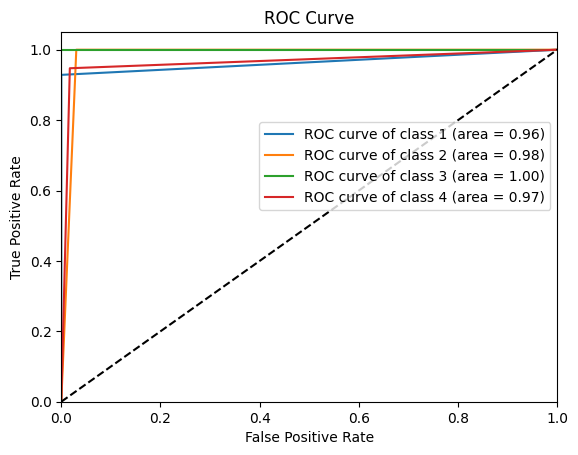

In [46]:
#@title Testing the Model - Confusion Matrix - ROC-AUC curves
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("For Model CRNN2D: ")
labels = []
predictions = []
for batch1 in test.as_numpy_iterator():
    X1, y1 = batch1
    labels.extend(list(y1))
    yhat1 = model.predict(X1, verbose=0)
    max = a = 0
    arr = np.ones(yhat1.shape[0])*-1
    for i in yhat1:
        max = np.argmax(i)
        arr[a] = max
        a+=1
    predictions.extend(list(arr))

labels = np.asarray(labels)
predictions = np.asarray(predictions)

classes = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
metrics(labels, predictions, classes)

plot_roc(labels, predictions)


avg_acc_list = []
avg_precision_list = []
avg_recall_list = []
avg_f1_list = []

acc_fold = accuracy_score(labels, predictions)
avg_acc_list.append(acc_fold)
precision_fold = precision_score(labels, predictions, average='macro')
avg_precision_list.append(precision_fold)
recall_fold = recall_score(labels, predictions, average='macro')
avg_recall_list.append(recall_fold)
f1_fold  = f1_score(labels, predictions, average='macro')
avg_f1_list.append(f1_fold)

print('Accuracy[{:.4f}] Precision[{:.4f}] Recall[{:.4f}] F1[{:.4f}] ]'.format(acc_fold, precision_fold, recall_fold, f1_fold ))
print('________________________________________________________________')

avg_acc = np.asarray(avg_acc_list)
avg_pre = np.asarray(avg_precision_list)
avg_recall = np.asarray(avg_recall_list)
avg_f1 = np.asarray(avg_f1_list)
print("\n")
print('Overall Accuracy[{:.4f}] Overall Precision[{:.4f}] Overall Recall[{:.4f}] Overall F1[{:.4f}]'.format(np.mean(avg_acc), np.mean(avg_pre), np.mean(avg_recall), np.mean(avg_f1)))


''' For Ragas '''
for i in os.listdir(data_dir[0]):
    print("For "+i+": ")
    labels = []
    predictions = []
    for batch1 in tests[i].as_numpy_iterator():
        X1, y1 = batch1
        labels.extend(list(y1))
        yhat1 = models[i].predict(X1, verbose=0)
        max = a = 0
        arr = np.ones(yhat1.shape[0])*-1
        for j in yhat1:
            max = np.argmax(j)
            arr[a] = max
            a+=1
        predictions.extend(list(arr))

    labels = np.asarray(labels)
    predictions = np.asarray(predictions)

    classes = [str(z+1) for z, p in enumerate(os.listdir(os.path.join(data_dir[0], i)))]
    # classes = np.array(classes)
    # classes+=1
    # classes = classes.tolist()

    metrics(labels, predictions, classes)

    plot_roc(labels, predictions)


    avg_acc_list = []
    avg_precision_list = []
    avg_recall_list = []
    avg_f1_list = []

    acc_fold = accuracy_score(labels, predictions)
    avg_acc_list.append(acc_fold)
    precision_fold = precision_score(labels, predictions, average='macro')
    avg_precision_list.append(precision_fold)
    recall_fold = recall_score(labels, predictions, average='macro')
    avg_recall_list.append(recall_fold)
    f1_fold  = f1_score(labels, predictions, average='macro')
    avg_f1_list.append(f1_fold)

    print('Accuracy[{:.4f}] Precision[{:.4f}] Recall[{:.4f}] F1[{:.4f}] ]'.format(acc_fold, precision_fold, recall_fold, f1_fold ))
    print('________________________________________________________________')

    avg_acc = np.asarray(avg_acc_list)
    avg_pre = np.asarray(avg_precision_list)
    avg_recall = np.asarray(avg_recall_list)
    avg_f1 = np.asarray(avg_f1_list)
    print("\n")
    print('Overall Accuracy[{:.4f}] Overall Precision[{:.4f}] Overall Recall[{:.4f}] Overall F1[{:.4f}]'.format(np.mean(avg_acc), np.mean(avg_pre), np.mean(avg_recall), np.mean(avg_f1)))

In [21]:
#Placeholder model history -> Import model histories
hists = {}
hists['Thaat_Asavari'] = {'loss': [1.7862979173660278, 1.2647273540496826, 1.0430389642715454, 0.921184778213501, 0.8732708096504211, 0.7361026406288147, 0.6580010056495667, 0.5860120058059692, 0.5369086861610413, 0.5436313152313232, 0.48544228076934814, 0.44885680079460144, 0.46665364503860474, 0.4425750970840454, 0.3656974136829376, 0.36154764890670776, 0.3445179760456085, 0.40148118138313293, 0.3452872931957245, 0.33660218119621277], 'accuracy': [0.29971590638160706, 0.5071022510528564, 0.5994318127632141, 0.6875, 0.6818181872367859, 0.7514204382896423, 0.7798295617103577, 0.8039772510528564, 0.8267045617103577, 0.7982954382896423, 0.8465909361839294, 0.8607954382896423, 0.8295454382896423, 0.8380681872367859, 0.8778409361839294, 0.8892045617103577, 0.8934659361839294, 0.8678977489471436, 0.8664772510528564, 0.8778409361839294], 'val_loss': [1.2507187128067017, 1.0601056814193726, 0.9820764660835266, 0.82415771484375, 0.7458889484405518, 0.5833333730697632, 0.4396752417087555, 0.497173547744751, 0.40579524636268616, 0.4471195638179779, 0.3288327157497406, 0.2953636944293976, 0.3006483018398285, 0.33415770530700684, 0.20674709975719452, 0.3560822904109955, 0.19056828320026398, 0.33851537108421326, 0.17826099693775177, 0.21964727342128754], 'val_accuracy': [0.5520833134651184, 0.6875, 0.6666666865348816, 0.71875, 0.8125, 0.8020833134651184, 0.9270833134651184, 0.8541666865348816, 0.875, 0.875, 0.9375, 0.9270833134651184, 0.9375, 0.875, 0.96875, 0.90625, 0.9583333134651184, 0.875, 0.96875, 0.9479166865348816]}

hists['Thaat_Bhairav'] = {'loss': [1.8962427377700806, 1.400253415107727, 1.1677323579788208, 1.0814403295516968, 0.9204156398773193, 0.8671311736106873, 0.7272987961769104, 0.7111855149269104, 0.664696455001831, 0.5917235612869263, 0.5970345139503479, 0.549094021320343, 0.5200815200805664, 0.44324320554733276, 0.4939673840999603, 0.4311557114124298, 0.4307152032852173, 0.4212365448474884, 0.4173494577407837, 0.3879489600658417], 'accuracy': [0.2740384638309479, 0.5024038553237915, 0.588942289352417, 0.629807710647583, 0.6875, 0.703125, 0.7584134340286255, 0.7536057829856873, 0.7848557829856873, 0.7980769276618958, 0.796875, 0.8185096383094788, 0.823317289352417, 0.8605769276618958, 0.832932710647583, 0.848557710647583, 0.8569711446762085, 0.854567289352417, 0.8425480723381042, 0.864182710647583], 'val_loss': [1.4726195335388184, 1.200326919555664, 0.8837743997573853, 0.9031489491462708, 0.6884117722511292, 0.6655213832855225, 0.47476160526275635, 0.5470958352088928, 0.5593864917755127, 0.38572439551353455, 0.36864593625068665, 0.3776952028274536, 0.32201069593429565, 0.2745775580406189, 0.22192466259002686, 0.24245724081993103, 0.2161254584789276, 0.28500059247016907, 0.1703304797410965, 0.19626638293266296], 'val_accuracy': [0.46875, 0.5859375, 0.7109375, 0.71875, 0.75, 0.8046875, 0.8828125, 0.8515625, 0.8515625, 0.90625, 0.8984375, 0.8671875, 0.921875, 0.9140625, 0.9609375, 0.9453125, 0.953125, 0.921875, 0.9609375, 0.9453125]}

hists['Thaat_Bhairavi'] = {'loss': [1.6766090393066406, 1.2355467081069946, 1.1221951246261597, 0.8986771106719971, 0.8862209320068359, 0.8517686724662781, 0.737966775894165, 0.6480671763420105, 0.6270272135734558, 0.5984817743301392, 0.500230610370636, 0.48563751578330994, 0.46002471446990967, 0.44426509737968445, 0.41213008761405945, 0.4671976864337921, 0.4960800111293793, 0.4482339918613434, 0.43140360713005066, 0.3420118987560272, 0.3117721974849701, 0.36675575375556946, 0.3498800992965698, 0.32224801182746887], 'accuracy': [0.3307291567325592, 0.4869791567325592, 0.5260416865348816, 0.66015625, 0.6497395634651184, 0.6744791865348816, 0.7135416865348816, 0.7486979365348816, 0.7473958134651184, 0.7604166865348816, 0.8177083134651184, 0.8177083134651184, 0.8151041865348816, 0.8216145634651184, 0.85546875, 0.8151041865348816, 0.8033854365348816, 0.8177083134651184, 0.8372395634651184, 0.8736979365348816, 0.8880208134651184, 0.8658854365348816, 0.8841145634651184, 0.8736979365348816], 'val_loss': [1.9197824001312256, 1.2157466411590576, 0.8046176433563232, 0.8315393924713135, 0.6173745393753052, 0.6751807332038879, 0.615627646446228, 0.6890684962272644, 0.77229905128479, 0.46707069873809814, 0.33356595039367676, 0.31238704919815063, 0.3855094015598297, 0.31572428345680237, 0.35613611340522766, 0.6270977258682251, 0.3309785723686218, 0.32721853256225586, 0.17031459510326385, 0.24779754877090454, 0.21057625114917755, 0.1692652702331543, 0.42705971002578735, 0.2439500093460083], 'val_accuracy': [0.34375, 0.4921875, 0.7421875, 0.703125, 0.828125, 0.765625, 0.7890625, 0.7734375, 0.6953125, 0.8828125, 0.9375, 0.9296875, 0.90625, 0.9453125, 0.9140625, 0.734375, 0.8984375, 0.890625, 0.96875, 0.9453125, 0.921875, 0.96875, 0.828125, 0.921875]}

hists['Thaat_Bilawal'] = {'loss': [2.0148112773895264, 1.579630732536316, 1.3210312128067017, 1.136154294013977, 0.9627901315689087, 0.9238255023956299, 0.8685345649719238, 0.7792402505874634, 0.7343901991844177, 0.7553524374961853, 0.7086319327354431, 0.6297881603240967, 0.6530724167823792, 0.5218003988265991, 0.5313276648521423, 0.5099185705184937, 0.456124484539032, 0.4366629123687744, 0.4453030824661255, 0.4709470868110657, 0.4537763297557831, 0.3806258738040924, 0.3974367678165436], 'accuracy': [0.2338709682226181, 0.4385080635547638, 0.5302419066429138, 0.6169354915618896, 0.6905242204666138, 0.6582661271095276, 0.6854838728904724, 0.7338709831237793, 0.7590726017951965, 0.7389112710952759, 0.757056474685669, 0.7913306355476379, 0.7701612710952759, 0.8286290168762207, 0.8215726017951965, 0.8175403475761414, 0.8457661271095276, 0.8548387289047241, 0.84375, 0.8457661271095276, 0.84375, 0.8830645084381104, 0.867943525314331], 'val_loss': [1.5931631326675415, 1.2747187614440918, 1.1564812660217285, 0.9881287217140198, 0.8185540437698364, 0.7344541549682617, 0.6285092830657959, 0.7393758296966553, 0.7373430132865906, 0.5405412316322327, 0.5254889130592346, 0.4137953221797943, 0.6590315103530884, 0.39207977056503296, 0.3745884299278259, 0.3389548659324646, 0.27073583006858826, 0.2557886242866516, 0.2656511068344116, 0.3051973283290863, 0.2715621590614319, 0.23577383160591125, 0.25517353415489197], 'val_accuracy': [0.4296875, 0.6640625, 0.625, 0.7578125, 0.7734375, 0.765625, 0.8203125, 0.75, 0.734375, 0.8359375, 0.84375, 0.90625, 0.71875, 0.921875, 0.90625, 0.9296875, 0.953125, 0.9609375, 0.9609375, 0.921875, 0.9453125, 0.9609375, 0.953125]}

hists['Thaat_Kafi'] = {'loss': [1.8831696510314941, 1.552916407585144, 1.3566612005233765, 1.2278413772583008, 1.1112600564956665, 1.0469257831573486, 1.029543399810791, 0.9458851218223572, 0.8924293518066406, 0.8278579711914062, 0.7914130687713623, 0.7431585192680359, 0.7123603224754333, 0.7209848165512085, 0.6998453140258789, 0.6448640823364258, 0.671887218952179, 0.6222267746925354, 0.6229427456855774, 0.6729013323783875, 0.5888445377349854], 'accuracy': [0.26889535784721375, 0.41715115308761597, 0.5014534592628479, 0.5843023061752319, 0.5959302186965942, 0.6366279125213623, 0.6431686282157898, 0.6736918687820435, 0.6911337375640869, 0.7194767594337463, 0.7223837375640869, 0.7383720874786377, 0.7478197813034058, 0.7456395626068115, 0.7638081312179565, 0.7805232405662537, 0.770348846912384, 0.7914243936538696, 0.7696220874786377, 0.7848837375640869, 0.8008720874786377], 'val_loss': [1.5054736137390137, 1.169077754020691, 1.0788706541061401, 1.0088955163955688, 1.043606162071228, 0.9349873661994934, 0.8293328285217285, 0.7194086909294128, 0.7470364570617676, 0.5955612063407898, 0.6861955523490906, 0.6153449416160583, 0.4924226999282837, 0.7306923866271973, 0.7745686173439026, 0.45738163590431213, 0.41444334387779236, 0.4287566840648651, 0.3690083920955658, 0.415688157081604, 0.368012398481369], 'val_accuracy': [0.4479166567325592, 0.6458333134651184, 0.640625, 0.6875, 0.6354166865348816, 0.7395833134651184, 0.6979166865348816, 0.7916666865348816, 0.75, 0.84375, 0.7916666865348816, 0.828125, 0.8645833134651184, 0.7291666865348816, 0.7395833134651184, 0.8958333134651184, 0.8697916865348816, 0.8697916865348816, 0.8854166865348816, 0.8697916865348816, 0.890625]}

hists['Thaat_Kalyan'] = {'loss': [1.8461695909500122, 1.3531702756881714, 1.1685130596160889, 1.0891398191452026, 0.9611619710922241, 0.8616544008255005, 0.8684744238853455, 0.8021348714828491, 0.7128620147705078, 0.6836398243904114, 0.6668009161949158, 0.6857938766479492, 0.6656975150108337, 0.6083224415779114, 0.5899803042411804, 0.5640853643417358, 0.5915552377700806, 0.5133682489395142, 0.48530587553977966, 0.5196734070777893, 0.481135755777359, 0.5034876465797424], 'accuracy': [0.25833332538604736, 0.4802083373069763, 0.5708333253860474, 0.5947916507720947, 0.6520833373069763, 0.6791666746139526, 0.675000011920929, 0.7052083611488342, 0.737500011920929, 0.7552083134651184, 0.7739583253860474, 0.7322916388511658, 0.7520833611488342, 0.7604166865348816, 0.7791666388511658, 0.7833333611488342, 0.7822916507720947, 0.7958333492279053, 0.8187500238418579, 0.8177083134651184, 0.8083333373069763, 0.815625011920929], 'val_loss': [1.4593489170074463, 1.2100298404693604, 1.1009721755981445, 0.9947627782821655, 0.8628220558166504, 0.7383661270141602, 1.1060349941253662, 0.6033302545547485, 0.5915399789810181, 0.6334010362625122, 0.5704218149185181, 0.43189793825149536, 0.5626156330108643, 0.3608263432979584, 0.45447322726249695, 0.30917754769325256, 0.2755775451660156, 0.41058069467544556, 0.3352375626564026, 0.4490205645561218, 0.3580014109611511, 0.3129153251647949], 'val_accuracy': [0.4453125, 0.578125, 0.6171875, 0.703125, 0.71875, 0.7421875, 0.5546875, 0.828125, 0.7890625, 0.7734375, 0.8203125, 0.875, 0.8203125, 0.90625, 0.875, 0.921875, 0.96875, 0.859375, 0.90625, 0.828125, 0.8828125, 0.921875]}

hists['Thaat_Khamaj'] = {'loss': [1.8097130060195923, 1.2850511074066162, 1.0938868522644043, 0.9141061305999756, 0.8462351560592651, 0.687977135181427, 0.6229872107505798, 0.6406330466270447, 0.565300464630127, 0.5116857886314392, 0.45399951934814453, 0.45229363441467285, 0.4714685380458832, 0.43181779980659485, 0.399802565574646, 0.3998076915740967], 'accuracy': [0.2867647111415863, 0.501838207244873, 0.5863970518112183, 0.6746323704719543, 0.7040441036224365, 0.7408088445663452, 0.7886029481887817, 0.7867646813392639, 0.8051470518112183, 0.8400735259056091, 0.845588207244873, 0.8566176295280457, 0.8125, 0.8547794222831726, 0.8621323704719543, 0.8474264740943909], 'val_loss': [1.5130361318588257, 1.1629035472869873, 0.9076523780822754, 0.812789261341095, 0.5416638255119324, 0.5937592387199402, 0.5041133761405945, 0.4903735816478729, 0.4369923770427704, 0.37615177035331726, 0.2918195426464081, 0.42255687713623047, 0.2720928192138672, 0.37604284286499023, 0.2909928262233734, 0.24565047025680542], 'val_accuracy': [0.5104166865348816, 0.59375, 0.6875, 0.75, 0.8229166865348816, 0.8229166865348816, 0.8854166865348816, 0.8541666865348816, 0.9166666865348816, 0.8958333134651184, 0.9583333134651184, 0.875, 0.9270833134651184, 0.8333333134651184, 0.9583333134651184, 0.9166666865348816]}

hists['Thaat_Marwa'] = {'loss': [1.7680710554122925, 1.116653561592102, 0.8149416446685791, 0.6726690530776978, 0.548978865146637, 0.5007924437522888, 0.46174871921539307, 0.38849368691444397, 0.36738380789756775, 0.3148036003112793, 0.2759328782558441, 0.2816191613674164, 0.2584919333457947, 0.2393883317708969, 0.1991719901561737, 0.15886716544628143], 'accuracy': [0.34375, 0.5868055820465088, 0.7170138955116272, 0.765625, 0.8211805820465088, 0.8489583134651184, 0.8454861044883728, 0.8697916865348816, 0.8975694179534912, 0.9045138955116272, 0.9201388955116272, 0.9149305820465088, 0.9270833134651184, 0.9270833134651184, 0.953125, 0.9652777910232544], 'val_loss': [1.1027330160140991, 0.8644852638244629, 0.5968800187110901, 0.5013638138771057, 0.4088921844959259, 0.3914886713027954, 0.37684789299964905, 0.2640151083469391, 0.17121803760528564, 0.15642379224300385, 0.10331380367279053, 0.1252867430448532, 0.12910112738609314, 0.11131417006254196, 0.09925892949104309, 0.0775667056441307], 'val_accuracy': [0.6041666865348816, 0.7604166865348816, 0.8854166865348816, 0.8333333134651184, 0.8854166865348816, 0.875, 0.875, 0.9270833134651184, 0.9895833134651184, 0.9895833134651184, 1.0, 0.9895833134651184, 0.9791666865348816, 0.9895833134651184, 0.9895833134651184, 1.0]}

hists['Thaat_Purvi'] = {'loss': [2.0097501277923584, 1.5163793563842773, 1.2039002180099487, 1.0605921745300293, 0.8960800766944885, 0.8748167753219604, 0.7383637428283691, 0.6502676606178284, 0.6556955575942993, 0.6083858013153076, 0.5453546643257141, 0.5055712461471558, 0.48557358980178833, 0.4886744022369385, 0.4744609296321869, 0.46347272396087646, 0.4147564172744751, 0.4010485112667084, 0.39717188477516174, 0.40916571021080017, 0.34338822960853577, 0.32646819949150085, 0.3598366677761078, 0.37128183245658875, 0.32230862975120544], 'accuracy': [0.2086397111415863, 0.43566176295280457, 0.5413603186607361, 0.6185661554336548, 0.6654411554336548, 0.6755514740943909, 0.720588207244873, 0.7711396813392639, 0.7408088445663452, 0.783088207244873, 0.7959558963775635, 0.8134191036224365, 0.8198529481887817, 0.7931985259056091, 0.8180146813392639, 0.8318014740943909, 0.8363970518112183, 0.8400735259056091, 0.84375, 0.8382353186607361, 0.8667279481887817, 0.8694853186607361, 0.8511029481887817, 0.8474264740943909, 0.859375], 'val_loss': [1.5643688440322876, 1.2333176136016846, 1.099111557006836, 0.9176949262619019, 0.7761752605438232, 0.7824987173080444, 0.5551403164863586, 0.5363020896911621, 0.40299075841903687, 0.5299850702285767, 0.4520597457885742, 0.49340420961380005, 0.3989386558532715, 0.5209650993347168, 0.3068386912345886, 0.33503150939941406, 0.2704535126686096, 0.2833947241306305, 0.2901301980018616, 0.223442941904068, 0.2330438643693924, 0.2499907910823822, 0.3782821595668793, 0.22280478477478027, 0.2251599282026291], 'val_accuracy': [0.574999988079071, 0.612500011920929, 0.625, 0.731249988079071, 0.7437499761581421, 0.731249988079071, 0.862500011920929, 0.8374999761581421, 0.9125000238418579, 0.824999988079071, 0.8999999761581421, 0.824999988079071, 0.918749988079071, 0.84375, 0.925000011920929, 0.918749988079071, 0.9437500238418579, 0.9312499761581421, 0.9375, 0.9750000238418579, 0.9437500238418579, 0.9312499761581421, 0.875, 0.9375, 0.9437500238418579]}

hists['Thaat_Todi'] = {'loss': [1.5074965953826904, 1.1594178676605225, 1.036057472229004, 0.9739977717399597, 0.935235321521759, 0.8276486396789551, 0.886160671710968, 0.7415489554405212, 0.6414812803268433, 0.6219618320465088, 0.5530745983123779, 0.5545248985290527, 0.5033870339393616, 0.5455708503723145, 0.4842835068702698, 0.5398169755935669, 0.48069438338279724, 0.4548836648464203, 0.4661969244480133, 0.4244689345359802, 0.3829525411128998, 0.3609987795352936, 0.3565290868282318, 0.39335066080093384, 0.36721697449684143, 0.31198567152023315], 'accuracy': [0.3265624940395355, 0.5015624761581421, 0.5484374761581421, 0.5921875238418579, 0.59375, 0.6640625, 0.628125011920929, 0.7124999761581421, 0.762499988079071, 0.7640625238418579, 0.792187511920929, 0.796875, 0.8062499761581421, 0.765625, 0.817187488079071, 0.7828124761581421, 0.8031250238418579, 0.8374999761581421, 0.807812511920929, 0.8531249761581421, 0.859375, 0.8500000238418579, 0.8687499761581421, 0.832812488079071, 0.862500011920929, 0.8656250238418579], 'val_loss': [1.1071406602859497, 1.0342742204666138, 0.934319257736206, 0.7478238940238953, 0.7501330375671387, 0.7452301979064941, 0.7407975196838379, 0.6981430649757385, 0.5964099764823914, 0.43259039521217346, 0.5322262048721313, 0.4491308927536011, 0.40995585918426514, 0.3871521055698395, 0.3116418123245239, 0.41837963461875916, 0.32333555817604065, 0.359667032957077, 0.41276630759239197, 0.36080265045166016, 0.26701831817626953, 0.20326006412506104, 0.3695850372314453, 0.23391450941562653, 0.17080157995224, 0.2036617547273636], 'val_accuracy': [0.5520833134651184, 0.5729166865348816, 0.5729166865348816, 0.7916666865348816, 0.7708333134651184, 0.71875, 0.71875, 0.7083333134651184, 0.8125, 0.8541666865348816, 0.8333333134651184, 0.8541666865348816, 0.84375, 0.8854166865348816, 0.9270833134651184, 0.8541666865348816, 0.9479166865348816, 0.8854166865348816, 0.8125, 0.90625, 0.9791666865348816, 0.96875, 0.8541666865348816, 0.9791666865348816, 0.9791666865348816, 0.96875]}

print(len(hists))



10


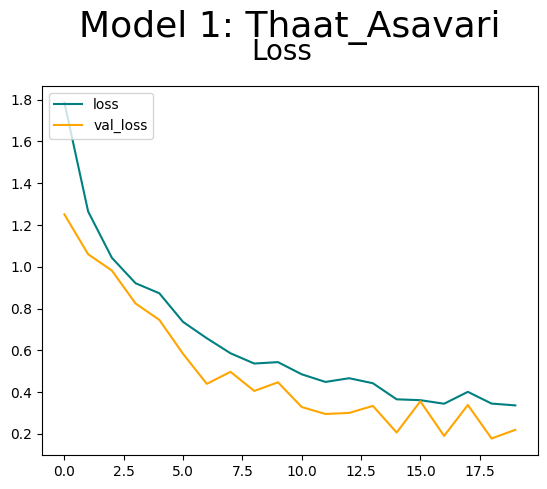

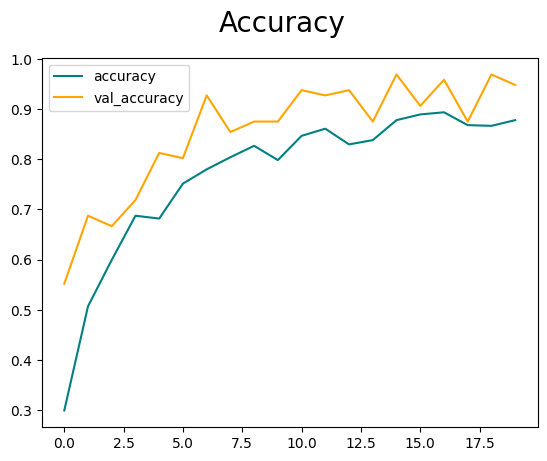

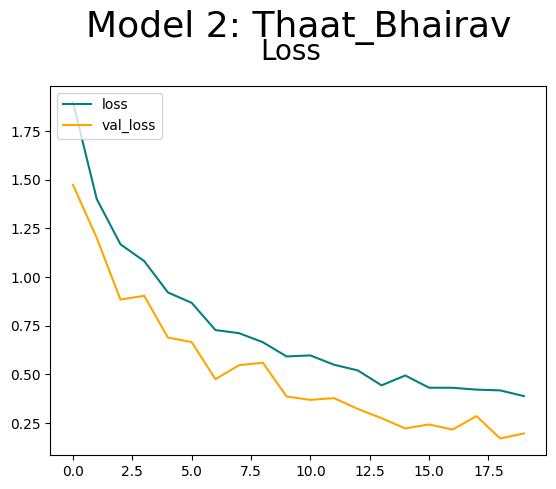

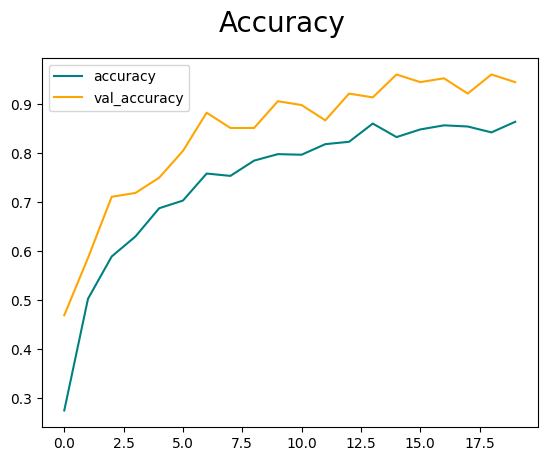

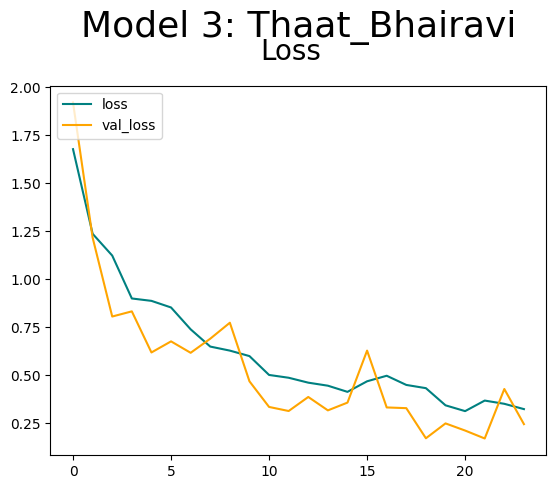

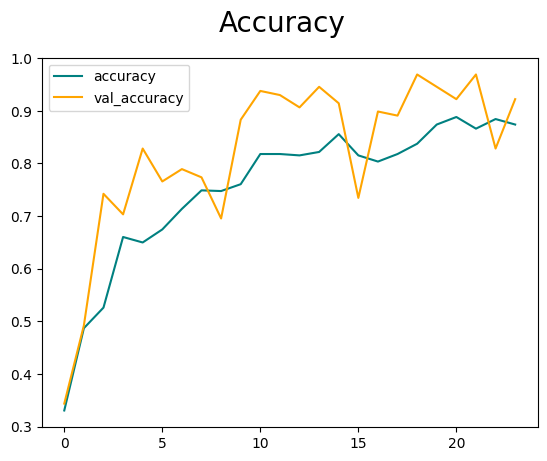

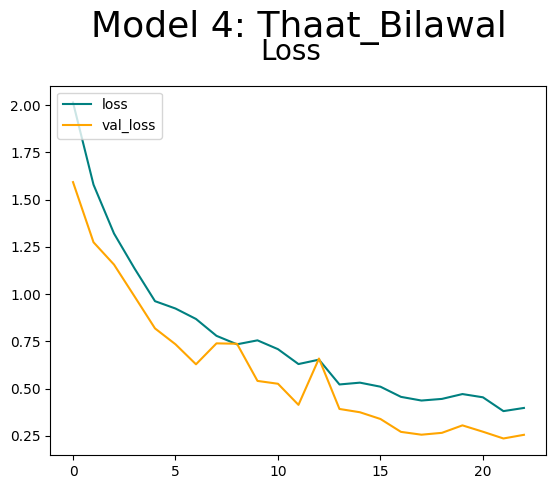

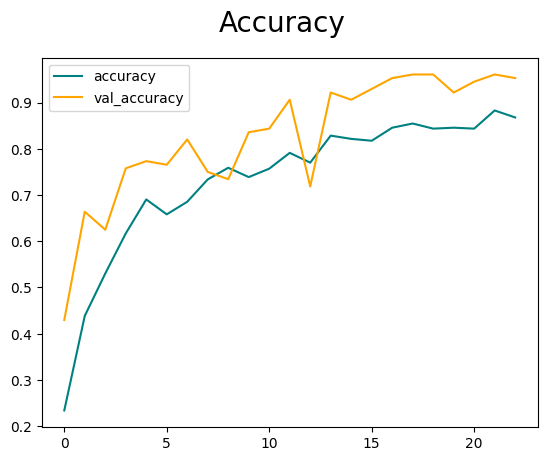

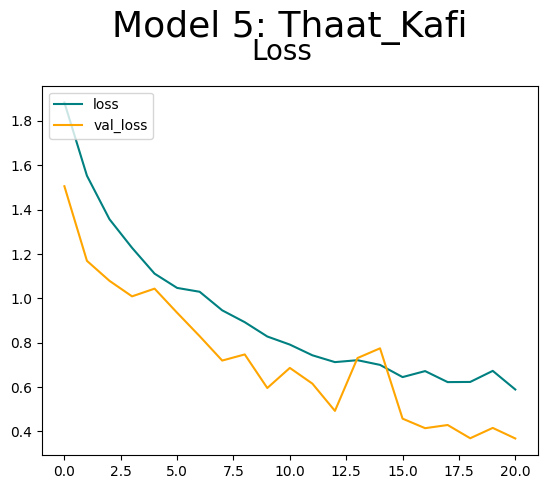

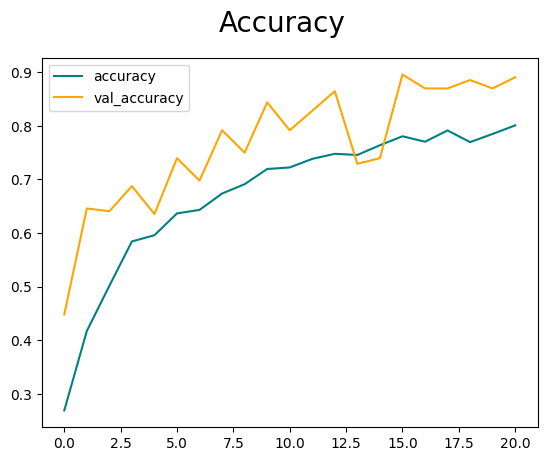

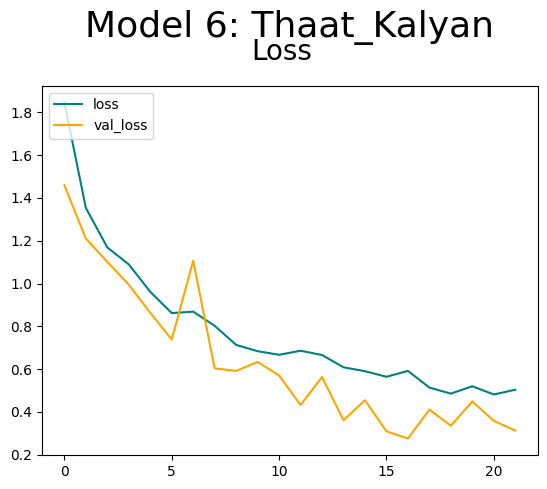

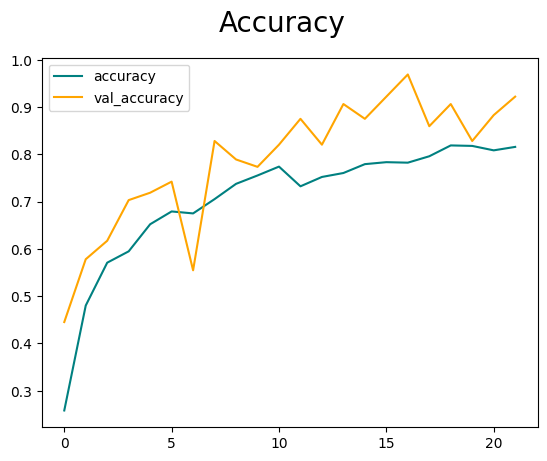

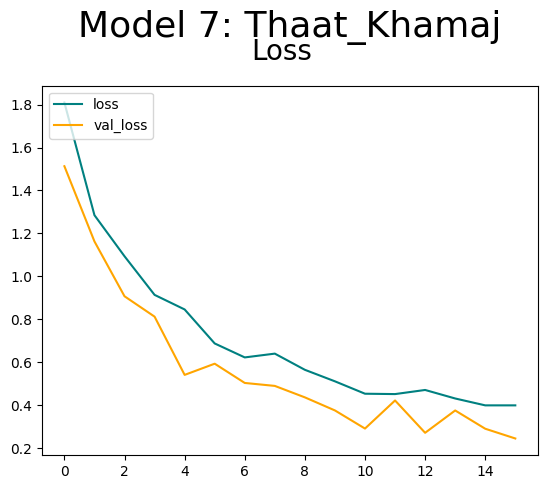

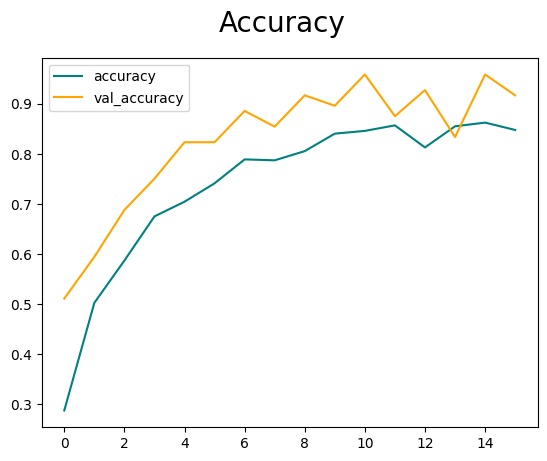

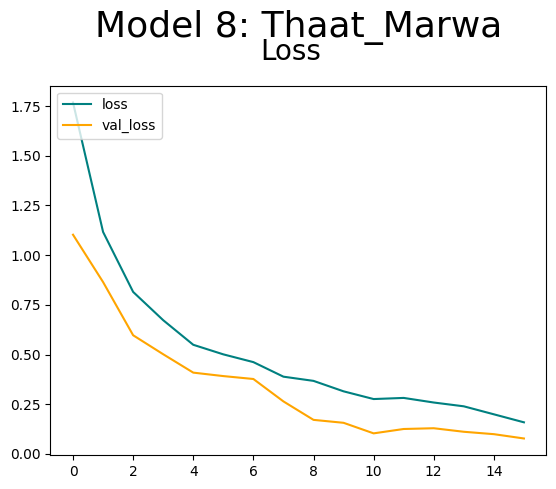

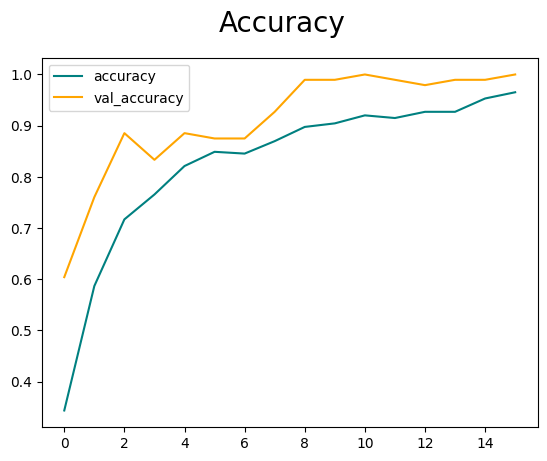

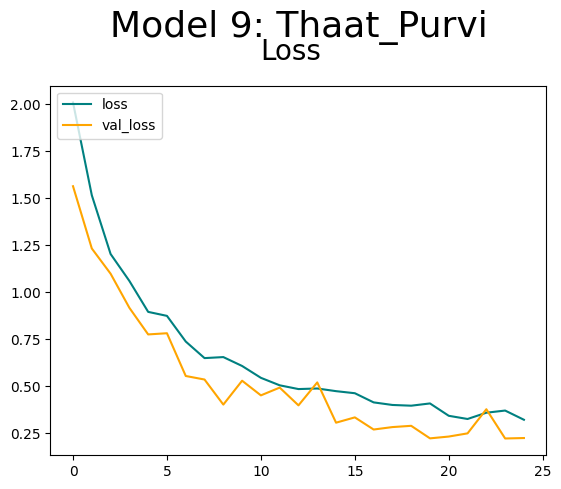

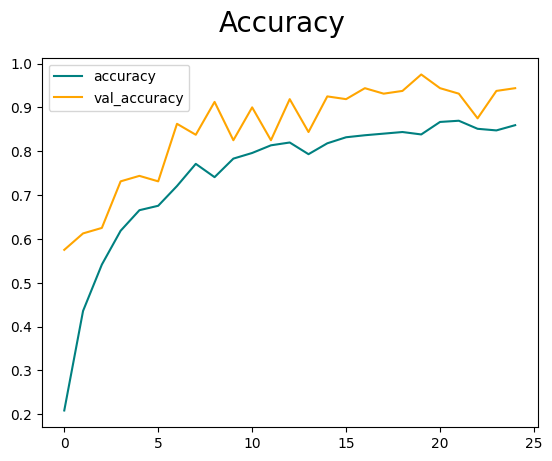

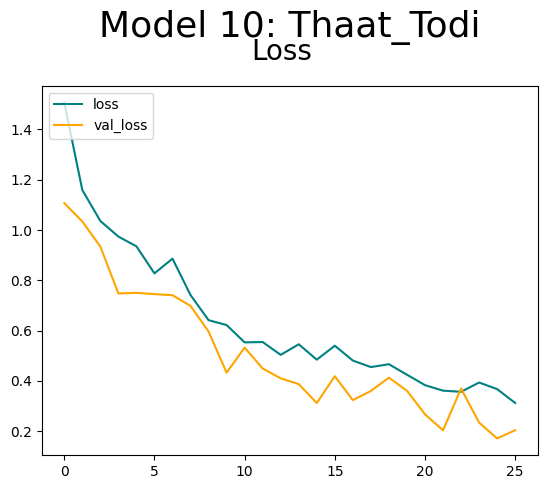

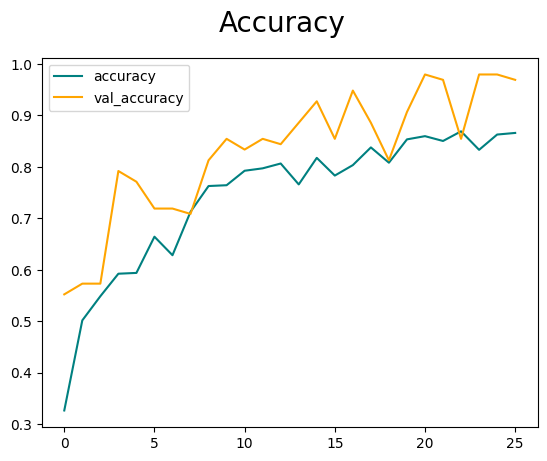

In [22]:
#@title Performance Graphs
import os
data_dir = [r'E:\Mini_Project\Review_1_data']
import matplotlib.pyplot as plt

''' Model 1 '''
# Loss
fig = plt.figure()
plt.title("Model 1: Thaat Classifier\n\n", loc='center', fontsize=26)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Accuracy
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


''' Rest of the models '''
a = 1
for i in os.listdir(data_dir[0]):
    title = "Model "+str(a)+": "+i+"\n"
    # Loss
    fig = plt.figure()
    plt.title(title, loc='center', fontsize=26)
    plt.plot(hists[i]['loss'], color='teal', label='loss')
    plt.plot(hists[i]['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    # Accuracy
    fig = plt.figure()
    plt.plot(hists[i]['accuracy'], color='teal', label='accuracy')
    plt.plot(hists[i]['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    a+=1